#Aprendizaje Supervisado utilizando KMeans

**Pasos a seguir:**

1. Descarga del Set de Datos.
2. Curacion (Recetas TP Exploración y Curación).
3. Generacion de Features.
4. Aprendizaje No Supervizado.
5. Presentacion de Resultados.

**Tareas:**

- Aplique la serie de pasos en 2 de las recetas que haya elaborado en el practico de Curación y Visualización.
- Observa alguna clase de separacion para el set de datos que tenemos? 
- Sabemos de antemano que tendriamos 2 centros de acumulacion naturales, si los pensamos como Verde/No-Verde. Pero si lo pensamos en terminos estacionales, tendriamos 4 (u 8). Considera alguna otra opción? 
- EXTRA: En el caso que sus resultados no sean directamente mapeables a tipo de espacio y/o estacionalidad, es capaz de identificar que esta separando el algoritmo? (Ejemplo, zonas densamente pobladas vs zonas no pobladas), esto puede requerir que asigne los puntos sobre un raster.


**Lineamientos Generales KMeans**

- Explorar distintas soluciones de clustering, particularmente, iteraciones, número de clusters (considere el método de Elbow para la cantidad "optima" de clusters), métricas de distancia (comente sobre las diferencias) y cualquier otra que considere relevante (tenga en cuenta que los metodos de este estilo suelen ser sensibles a las condiciones iniciales). Para el modelo seleccionado:

- Calcular las métricas pertinentes sobre los clusters resultantes.
- Tomar ejemplos aleatorios y pensar por qué están en un cluster y no en otro.
- Contrastar la clasificación en clusters con las etiquetas de clases, tanto gráficamente como analítica. 
- Dada la naturaleza del problema, puede pensar en elaborar una matriz confusion para presentar parte de la solución, cuales clases utilizaria?

##Resolución:



Utilizaremos las Recetas A y D, las cuales también fueron utilizadas para el trabajo practico de Aprendizaje Supervisado. Recordemos que estos dataset se obtuvieron a partir de dos conjuntos de datos, uno para espacios verdes y otro para espacios no verdes, a los cuales se le aplicaron de igual forma el preprocesamiento marcado por cada una de las recetas y luego fueron unidos para poner en marcha los algoritmos de Aprendizaje Supervisado elegidos.

  * Receta A:
* Leer los datos.
* Extraer las columnas de interes.
* Desechar valores nulos.
* Filtrar por nubosidad < 10%.
* Remocion de Outliers (a nivel general sin considerar estacionalidad).
* Grabar los datos transformados.

  * Receta D:
* Leer los datos.
* Extraer las columnas de interes.
* Remoción de Outliers (a nivel estacional - SIN refinar por año).
* Imputar valores nulos (definir el criterio, o estadistico, media, mediana, etc).
* Filtrar por nubosidad:
< 40%
* NORMALIZACION.
* Grabar los datos transformados.

Por otro lado, estos dataset cuentan con el agregado de features extras como año, mes y target.  Dado que estamos en un contexto de Aprendizaje NO supervisado, esta última variable será considerada como una variable categórica más.

###Carga de datos (curados y preprocesados)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import random

from sklearn.cluster import KMeans #,MeanShift

from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from yellowbrick.cluster import SilhouetteVisualizer 

In [2]:
!gdown https://drive.google.com/file/d/1tH9oqyL2KtNerYWH8012raDla7iko7jL/view?usp=sharing --fuzzy
file_name1 = 'df_A_modelo_encode.csv'
df_A= pd.read_csv(file_name1)

Downloading...
From: https://drive.google.com/uc?id=1tH9oqyL2KtNerYWH8012raDla7iko7jL
To: /content/df_A_modelo_encode.csv
100% 49.6M/49.6M [00:00<00:00, 127MB/s]


In [3]:
!gdown https://drive.google.com/file/d/1tI7pc0yVTkHK5sBuK4M0CEyEoPoj-ATS/view?usp=sharing --fuzzy
file_name2 = 'df_C_modelo_encode.csv'
df_C= pd.read_csv(file_name2) #cargamos el dataset de la receta C, para luego hacer un escalado incluyendo las variables temporales

Downloading...
From: https://drive.google.com/uc?id=1tI7pc0yVTkHK5sBuK4M0CEyEoPoj-ATS
To: /content/df_C_modelo_encode.csv
100% 61.7M/61.7M [00:00<00:00, 163MB/s]


In [4]:
df_A.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,target,año,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
count,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,1.700900e+05,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000,170090.000000
mean,0.364385,1.051277,1.045381,0.191310,0.994003,0.053580,0.125309,0.269195,0.241356,0.416255,1.885898e+04,0.692545,2019.393245,6.559433,0.209413,0.239567,0.273808,0.277212
std,0.128667,0.231609,0.215483,0.049479,0.112413,0.081421,0.033215,0.042451,0.040652,1.476307,6.864772e+04,0.461441,1.397456,3.620712,0.406891,0.426821,0.445913,0.447623
min,-0.009102,0.254644,0.308995,0.034613,0.638591,-0.206024,0.042400,0.119800,0.107700,0.000000,4.225951e+02,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.258850,0.877130,0.882758,0.161540,0.913383,-0.008449,0.100000,0.236300,0.212500,0.000000,2.929467e+03,0.000000,2018.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351721,1.044740,1.045812,0.194309,0.975294,0.043326,0.123250,0.269200,0.239700,0.000000,6.336731e+03,1.000000,2019.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,0.465916,1.200434,1.194116,0.223182,1.064357,0.110543,0.148100,0.300400,0.269400,0.000000,3.136548e+04,1.000000,2021.000000,10.000000,0.000000,0.000000,1.000000,1.000000
max,0.747038,1.770667,1.744506,0.328613,1.400520,0.325748,0.248600,0.403100,0.373200,9.826493,1.370630e+06,1.000000,2022.000000,12.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_A.columns

Index(['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
       'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
       'raster', 'clouds_on_raster', 'area_m2', 'date', 'target', 'año', 'mes',
       'estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera',
       'estacion_Verano'],
      dtype='object')

In [ ]:
df_C.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,target,año,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano
count,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,2.099750e+05,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000
mean,0.360393,1.056179,1.048979,0.186304,0.995806,0.055157,0.127558,0.271164,0.242459,3.906942,1.868400e+04,0.697412,2019.470213,6.445096,0.221245,0.233175,0.267460,0.278119
std,0.129677,0.249764,0.229699,0.053963,0.125364,0.082092,0.034765,0.042764,0.041735,8.843725,6.888406e+04,0.459380,1.407488,3.600756,0.415086,0.422854,0.442636,0.448073
min,-0.009102,-0.038760,0.299199,-0.048641,0.474378,-0.146854,0.042400,0.136800,0.093400,0.000000,4.225951e+02,0.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250544,0.878140,0.888130,0.159433,0.911408,-0.008313,0.102100,0.238300,0.213100,0.000000,2.928527e+03,0.000000,2018.000000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,0.349143,1.046311,1.047573,0.192141,0.974401,0.046276,0.125800,0.271500,0.240900,0.000000,6.128520e+03,1.000000,2020.000000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,0.463446,1.205720,1.199225,0.218981,1.064299,0.113271,0.150400,0.301800,0.270200,0.533689,3.136548e+04,1.000000,2021.000000,10.000000,0.000000,0.000000,1.000000,1.000000
max,0.762083,2.071175,1.973077,0.369972,1.656963,0.330231,0.287400,0.404600,0.395550,37.477434,1.370630e+06,1.000000,2022.000000,12.000000,1.000000,1.000000,1.000000,1.000000


###Generación de features extras

In [4]:
df_A['date'] = pd.to_datetime(df_A.date, format='%Y/%m/%d')
df_C['date'] = pd.to_datetime(df_C.date, format='%Y/%m/%d')


Generamos la columna estación como variable cualitativa para realizar más adelante tablas de contingencia.

In [5]:
#le asignamos a cada fecha la estación del año correspondiente.
from datetime import date, datetime

def season_of_date(date):
    year = str(date.year)
    seasons = {'Otoño': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Invierno': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Primavera': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['Primavera']:
        return 'Primavera'
    if date in seasons['Invierno']:
        return 'Invierno'
    if date in seasons['Otoño']:
        return 'Otoño'
    else:
        return 'Verano'

# Assuming df has a date column of type `datetime`
df_A['estacion'] = df_A.date.map(season_of_date)
df_C['estacion'] = df_C.date.map(season_of_date)

Como nuestros dataset tienen incluidas variables temporales, sólo se generará la columna 'week' basada en el número de la semana del año. Esta variable toma 53 valores distintos.

In [6]:
#función que agrega el número de la semana del año a partir de la columna de fechas ('date')
def prc_dates(df,col='date',drop_col=True):

  #df[col]=pd.to_datetime(df[col])
  df['week']=df[col].apply(lambda x:float(x.strftime('%U')))
  #df.drop('target',axis=1,inplace=True)
  if drop_col:
    df.drop(col,axis=1,inplace=True)
  return df

In [7]:
df_A_km= df_A.copy()
df_D_km= df_C.copy()
df_A_km= prc_dates(df_A_km) #dataset para KMeans, receta A
df_D_km= prc_dates(df_D_km) #dataset para KMeans, receta D

Renombramos la variable 'target' como 'espacio' haciendo referencia a espacios verdes y no verdes como herramienta para realizar interpretaciones de los clusters obtenidos.

In [8]:
df_A_km=df_A_km.rename(columns={'target':'espacio'})


In [10]:
#df_A_km['espacio']=df_A_km['espacio'].astype(str)


In [9]:
df_D_km=df_D_km.rename(columns={'target':'espacio'})

In [12]:
#df_D_km['espacio']=df_D_km['espacio'].astype(str)

Determinamos las variables que utilizaremos en el algoritmo KMeans, en ambas recetas. Debido al análisis que realizamos con PCA en ambas recetas, decidimos no considerar la variable 'area_m2'.

In [10]:
#columnas de interés receta A

col_A= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes', 'week']

#'raster', 'clouds_on_raster', 'area_m2'

#columnas de interés receta D

col_D= ['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median',
        'mes', 'week','estacion_Invierno', 'estacion_Otoño', 'estacion_Primavera','estacion_Verano']
#'raster', 'clouds_on_raster', 'area_m2'

In [11]:
df_D_km1=df_D_km.copy()
df_D_km1=df_D_km1.drop(labels='año', axis=1)

Preparamos el dataset de la receta D: Normalización

In [12]:
from sklearn.preprocessing import RobustScaler

transformer = RobustScaler()
df_D_escal1=df_D_km1.copy()
df_D_escal1.loc[:,col_D]=transformer.fit_transform(df_D_escal1[col_D])

In [13]:
df_D_escal1.describe()

,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,clouds_on_raster,area_m2,espacio,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,week
count,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,2.099750e+05,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000,209975.000000
mean,0.052838,0.030122,0.004519,-0.098033,0.140001,0.073043,0.036399,-0.005286,0.027300,3.906942,1.868400e+04,0.697412,-0.079272,0.221245,0.233175,0.267460,0.278119,-0.009734
std,0.609094,0.762451,0.738355,0.906206,0.819951,0.675189,0.719767,0.673456,0.730911,8.843725,6.888406e+04,0.459380,0.514394,0.415086,0.422854,0.442636,0.448073,0.562644
min,-1.682682,-3.312377,-2.405609,-4.043457,-3.270445,-1.588449,-1.726708,-2.121259,-2.583187,0.000000,4.225951e+02,0.000000,-0.857143,0.000000,0.000000,0.000000,0.000000,-0.928571
25%,-0.463120,-0.513375,-0.512523,-0.549272,-0.412012,-0.448985,-0.490683,-0.522834,-0.486865,0.000000,2.928527e+03,0.000000,-0.571429,0.000000,0.000000,0.000000,0.000000,-0.535714
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.128520e+03,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.536880,0.486625,0.487477,0.450728,0.587988,0.551015,0.509317,0.477166,0.513135,0.533689,3.136548e+04,1.000000,0.428571,0.000000,0.000000,1.000000,1.000000,0.464286
max,1.939581,3.128582,2.974983,2.986321,4.464358,2.335464,3.345756,2.096062,2.708406,37.477434,1.370630e+06,1.000000,0.714286,1.000000,1.000000,1.000000,1.000000,0.928571


##KMeans Receta A

Primer acercamiento utilizando gráficos de dispersión.

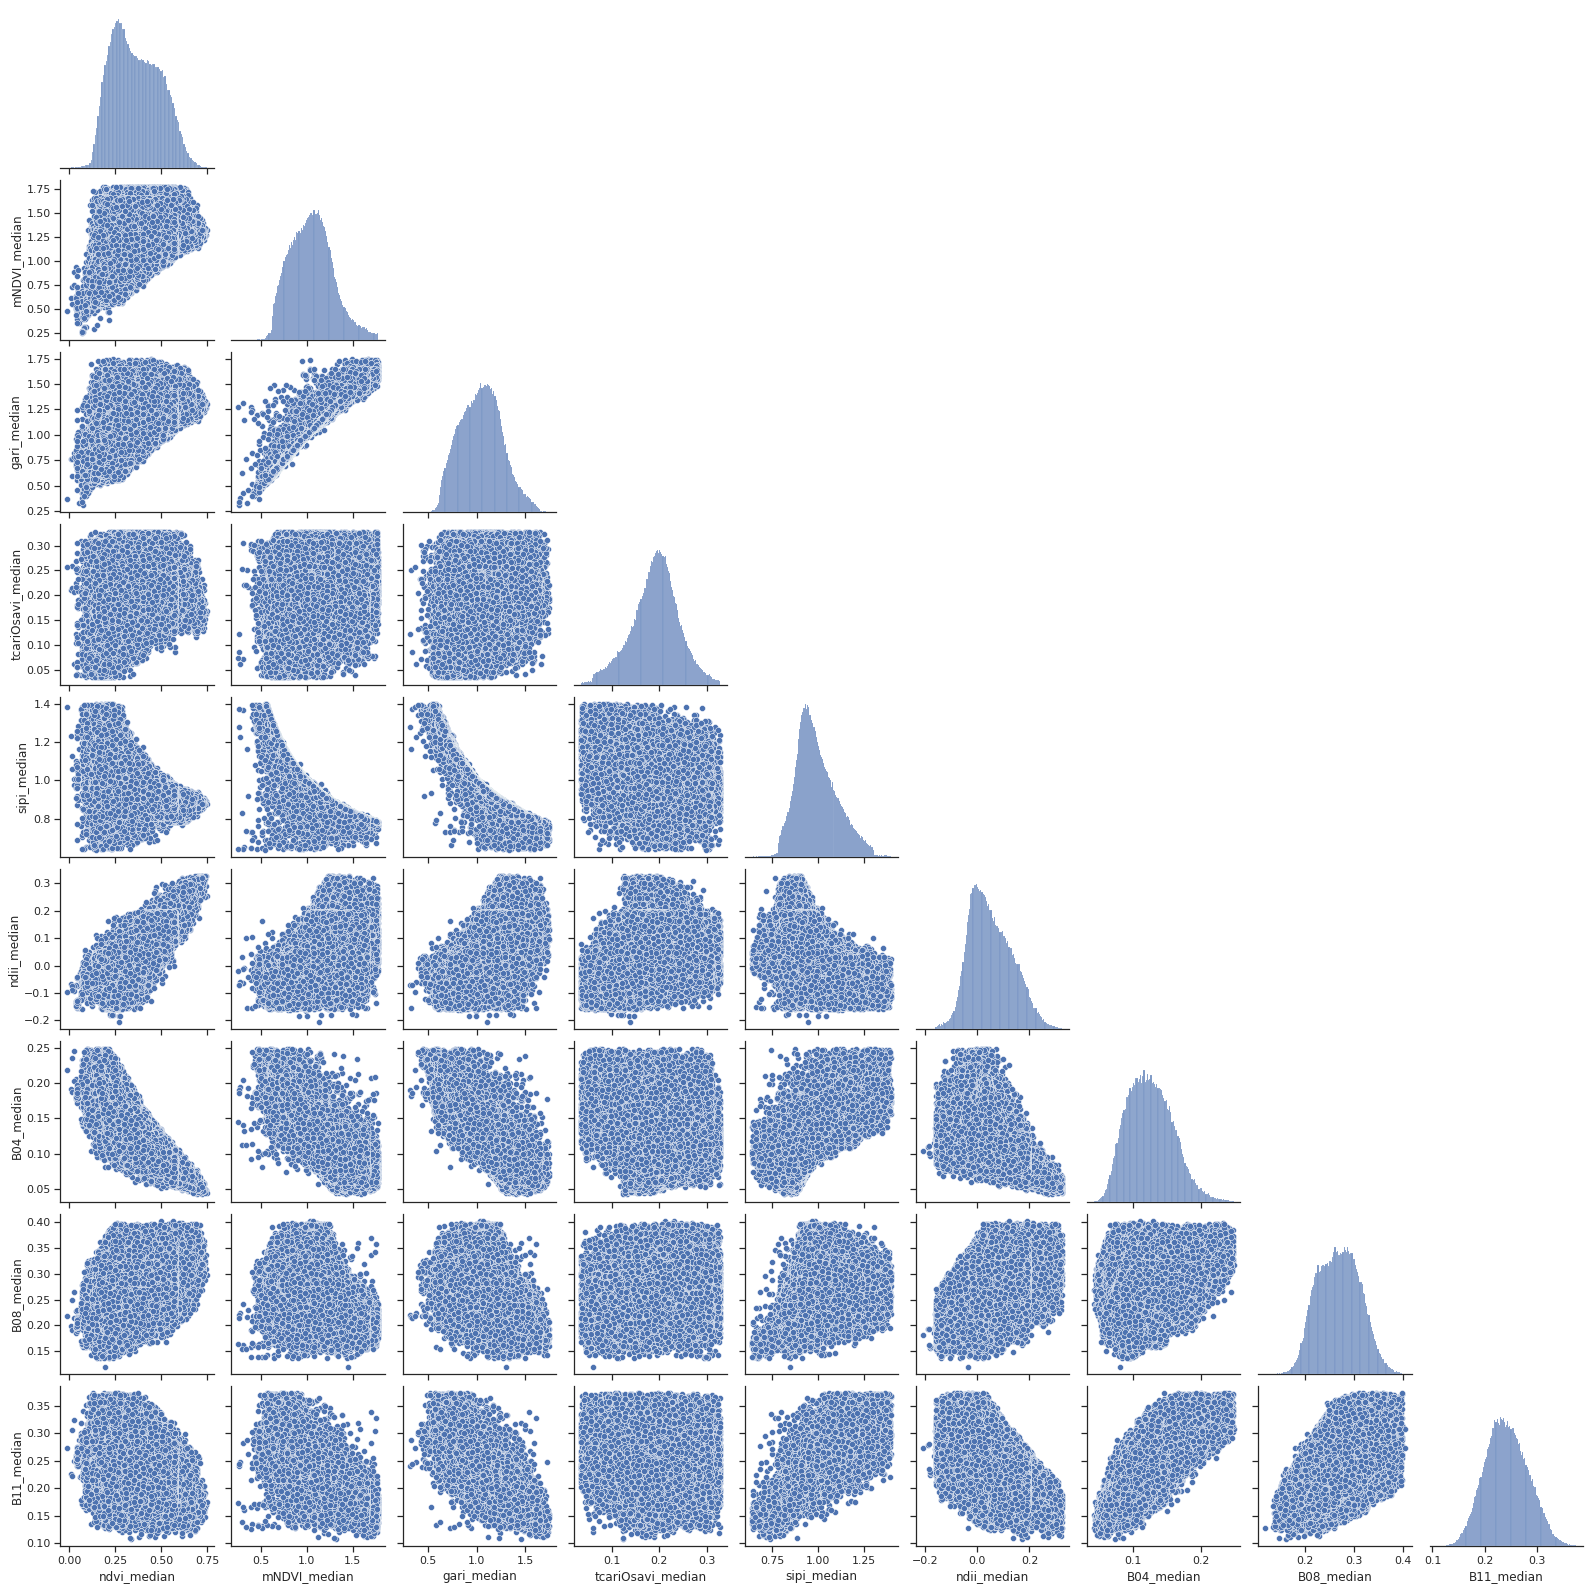

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_A_km, vars=['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median'], corner=True)

Como se puede observar a simple vista, los gráficos de dispersión de a pares no nos muestran posibles conglomerados. La distribución de cada variable numérica no presenta comportamiento bimodal o de alta variabilidad, que serían algunas de las condiciones que nos permitirían realizar elecciones de variables para incluir en nuestro algoritmo de clustering. Asímismo, las gráficas proporcionadas por el pairplot no nos permiten considerar una primera elección de un $k$ para implementar KMeans por lo que utilizaremos el método del codo para elegir este hiperparámetro.

##Elbow

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

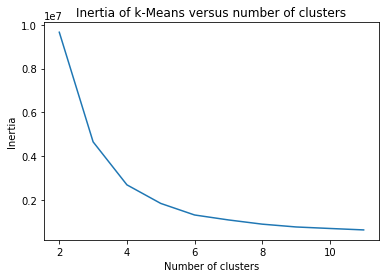

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i,random_state=10).fit(df_A_km[col_A]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

Vemos que podemos tomar valores de $k$ entre 3 y 6. Podemos apoyarnos también con los gráficos de silueta para tomar la decisión, ya que hemos quitado una variable con mucho peso.


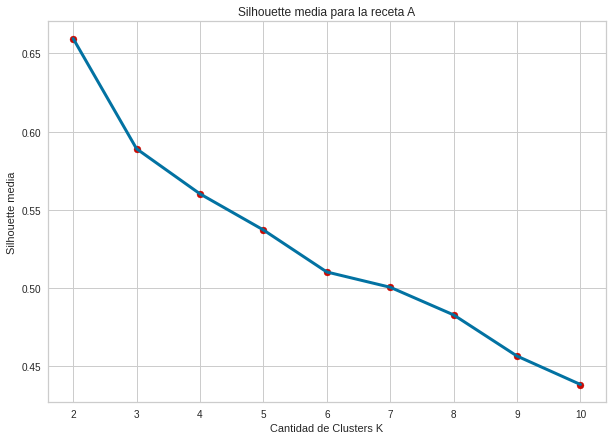

In [ ]:
#ojo, tarda 50 minutos

K = np.arange(2,11)

lista_sil = []

for k in range(2,11):
    km = KMeans(n_clusters=k)
    km = km.fit(df_A_km[col_A])
    
    etiquetas = km.labels_
    
    valor_medio_sil = silhouette_score(df_A_km[col_A], etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil, c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para la receta A')

plt.show()

El gráfico nos muestra que con un $k=2$ obtendríamos una puntuación de Silhouette de más de $0.65$ (recordemos que mientras más cerca de 1, mejor serán las agrupaciones que se formen).



Gráficos de silueta para distintos valores de $k$ 

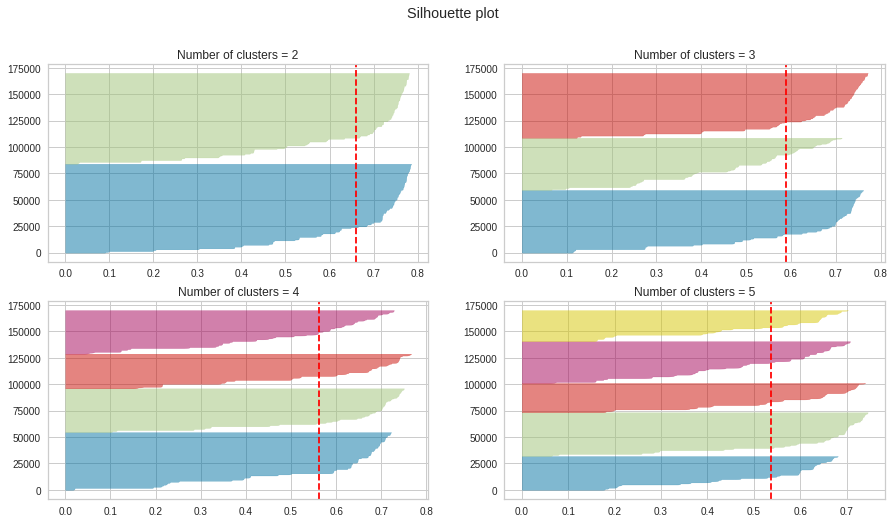

In [ ]:

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from yellowbrick.cluster import SilhouetteVisualizer 

fig, ax = plt.subplots(2, 2, figsize=(15,8)) 
for i in [2,3,4,5]: 
    ''' 
    Crear instancia de KMeans para diferentes números de clústeres 
    ''' 
    km = KMeans(n_clusters=i, init='k-means++', random_state=42) 
    q, mod = divmod(i, 2) 
    ''' 
    Crear instancia de SilhouetteVisualizer con instancia de KMeans 
    Ajuste el visualizador 
    ''' 
    visualizador = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod]) 
    visualizador.fit(df_A_km[col_A])

fig.suptitle("Silhouette plot")
ax[0, 0].title.set_text('Number of clusters = 2')
ax[0, 1].title.set_text('Number of clusters = 3')
ax[1, 0].title.set_text('Number of clusters = 4')
ax[1, 1].title.set_text('Number of clusters = 5')
plt.show()

La puntuación de silueta para cada grupo está por encima de las puntuaciones de silueta medias en todos los casos. Sin embargo, se pueden observar  fluctuaciones en el tamaño  de las parcelas de silueta en los casos donde $k=4$ o $k=5$ . Notar que para el gráfico con n_cluster igual a $2$, el grosor es más uniforme que en el resto. Por lo tanto, podemos seleccionar el número óptimo de grupos como 2.

**Algoritmo KMeans**

In [14]:
n_clust =2 #Se selecciona el número de clusters (k)

km = KMeans(n_clusters=n_clust, random_state=10)
km.fit(df_A_km[col_A]) 

clusters = km.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_A=df_A_km.copy() #Se hace una copia del df 
df_clusters_A['kmeans_clust'] = km.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km.labels_)+1, 'clusters')
df_clusters_A.head(4)

Nro Clusters encontrados:  2 clusters


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,raster,...,espacio,año,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,estacion,week,kmeans_clust
0,0.547001,1.301351,1.285897,0.212710,0.884216,0.166902,0.0779,0.2645,0.18770,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1,2017,1,0,0,0,1,Verano,1.0,1
1,0.534292,1.059602,1.061493,0.240232,0.971875,0.145259,0.0988,0.3329,0.25420,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1,2017,1,0,0,0,1,Verano,1.0,1
2,0.525454,1.057045,1.058720,0.203292,0.973017,0.158971,0.1062,0.3415,0.24640,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1,2017,1,0,0,0,1,Verano,1.0,1
3,0.593190,1.072501,1.073903,0.211842,0.966202,0.195676,0.1037,0.3928,0.26675,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1,2017,1,0,0,0,1,Verano,1.0,1


Representación gráfica usando dos variables

In [15]:
# Predicting the clusters
labels_A = km.predict(df_A_km[col_A])
# Getting the cluster centers
C_A = km.cluster_centers_

Para graficar tomamos las variables 'ndvi_median' y 'gari_median' (podríamos haber considerado cualquier otro par)

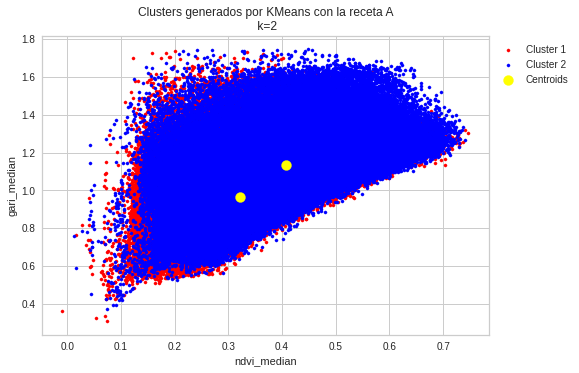

In [16]:
# Visualizacion grafica de los clusters
plt.scatter(df_clusters_A.iloc[labels_A == 0, 0], df_clusters_A.iloc[labels_A == 0, 2], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_A.iloc[labels_A == 1, 0], df_clusters_A.iloc[labels_A == 1, 2], s = 10, c = 'blue', label = 'Cluster 2')
# plt.scatter(df_clusters_A.iloc[labels == 2, 0], df_clusters_A.iloc[labels == 2, 2], s = 10, c = 'green', label = 'Cluster 3')
# plt.scatter(df_clusters_A.iloc[labels == 3, 0], df_clusters_A.iloc[labels == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(C_A[:, 0], C_A[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta A\n k={n_clust}')
plt.xlabel('ndvi_median')
plt.ylabel('gari_median')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Representación gráfica usando tres variables

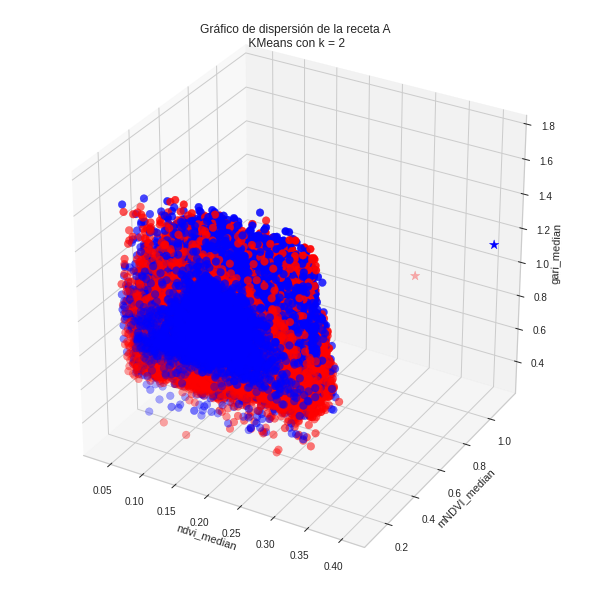

In [19]:
colores=['red','blue']#,'green','cyan','yellow','orange'
asignar=[]
for row in labels_A:
    asignar.append(colores[row])

fig =  plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(df_A_km.iloc[:, 3], df_A_km.iloc[:, 8],df_A_km.iloc[:, 2], c=asignar,s=60)
ax.scatter(C_A[:, 0], C_A[:, 1], C_A[:, 2], marker='*', c=colores, s=100)
#ax.view_init(10,80) 

ax.set_xlabel('ndvi_median')
ax.set_ylabel('mNDVI_median')
ax.set_zlabel('gari_median')
plt.title(f'Gráfico de dispersión de la receta A\n KMeans con k = {n_clust}')
plt.show()

Los gráficos nos muestran que los clusters formados están superpuestos.

Métricas de los clusters encontrados


In [ ]:
# Calculate Silhoutte Score
#
score = metrics.silhouette_score(df_A_km[col_A], km.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.660


La puntuación de Silhoette nos sugiere que los clusters que se formaron no son de tan mala calidad, pero observando el gráfico vemos que los centroides quedan por fuera de los clusters y puede suceder porque los datos en esta receta no están escalados. 

Tabla de contingencia

In [17]:
round(pd.crosstab(df_clusters_A.kmeans_clust, df_clusters_A.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.16,0.33,0.49
1,0.15,0.36,0.51
All,0.31,0.69,1.00


Ambos clusters no pueden ser caracterizados en función del tipo de espacio.

In [18]:
round(pd.crosstab(df_clusters_A.kmeans_clust, df_clusters_A.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.18,0.00,0.27,0.04,0.49
1,0.02,0.24,0.00,0.24,0.51
All,0.21,0.24,0.27,0.28,1.00


Sólo podemos decir que el cluster $0$  contiene con seguridad observaciones relacionadas a la estación primavera  y  el $1$ contiene, con seguridad, registros relacionados con el otoño. El resto de las estaciones están mezcladas entre ambos clusters.

**Contraste de etiquetas**

In [19]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_A.estacion, labels_A, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
Invierno,31415,4204,35619
Otoño,0,40748,40748
Primavera,46572,0,46572
Verano,6118,41033,47151
All,84105,85985,170090


In [20]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_A.espacio, labels_A, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
0,27201,25094,52295
1,56904,60891,117795
All,84105,85985,170090


Esta tabla nos dice que si pudieramos agrupar los espacios no verdes en el cluster $0$ y los verdes en el cluster $1$, habría muchos falsos negativos y positivos para ambas clases.

In [21]:
from sklearn import metrics 
print(metrics.classification_report(df_clusters_A.espacio, labels_A))

              precision    recall  f1-score   support

           0       0.32      0.52      0.40     52295
           1       0.71      0.52      0.60    117795

    accuracy                           0.52    170090
   macro avg       0.52      0.52      0.50    170090
weighted avg       0.59      0.52      0.54    170090



Claramente, si utilizaramos estas etiquetas para implementar en un algoritmo de aprendizaje supervisado, los resultados no serían los mejores.

##KMeans Receta D

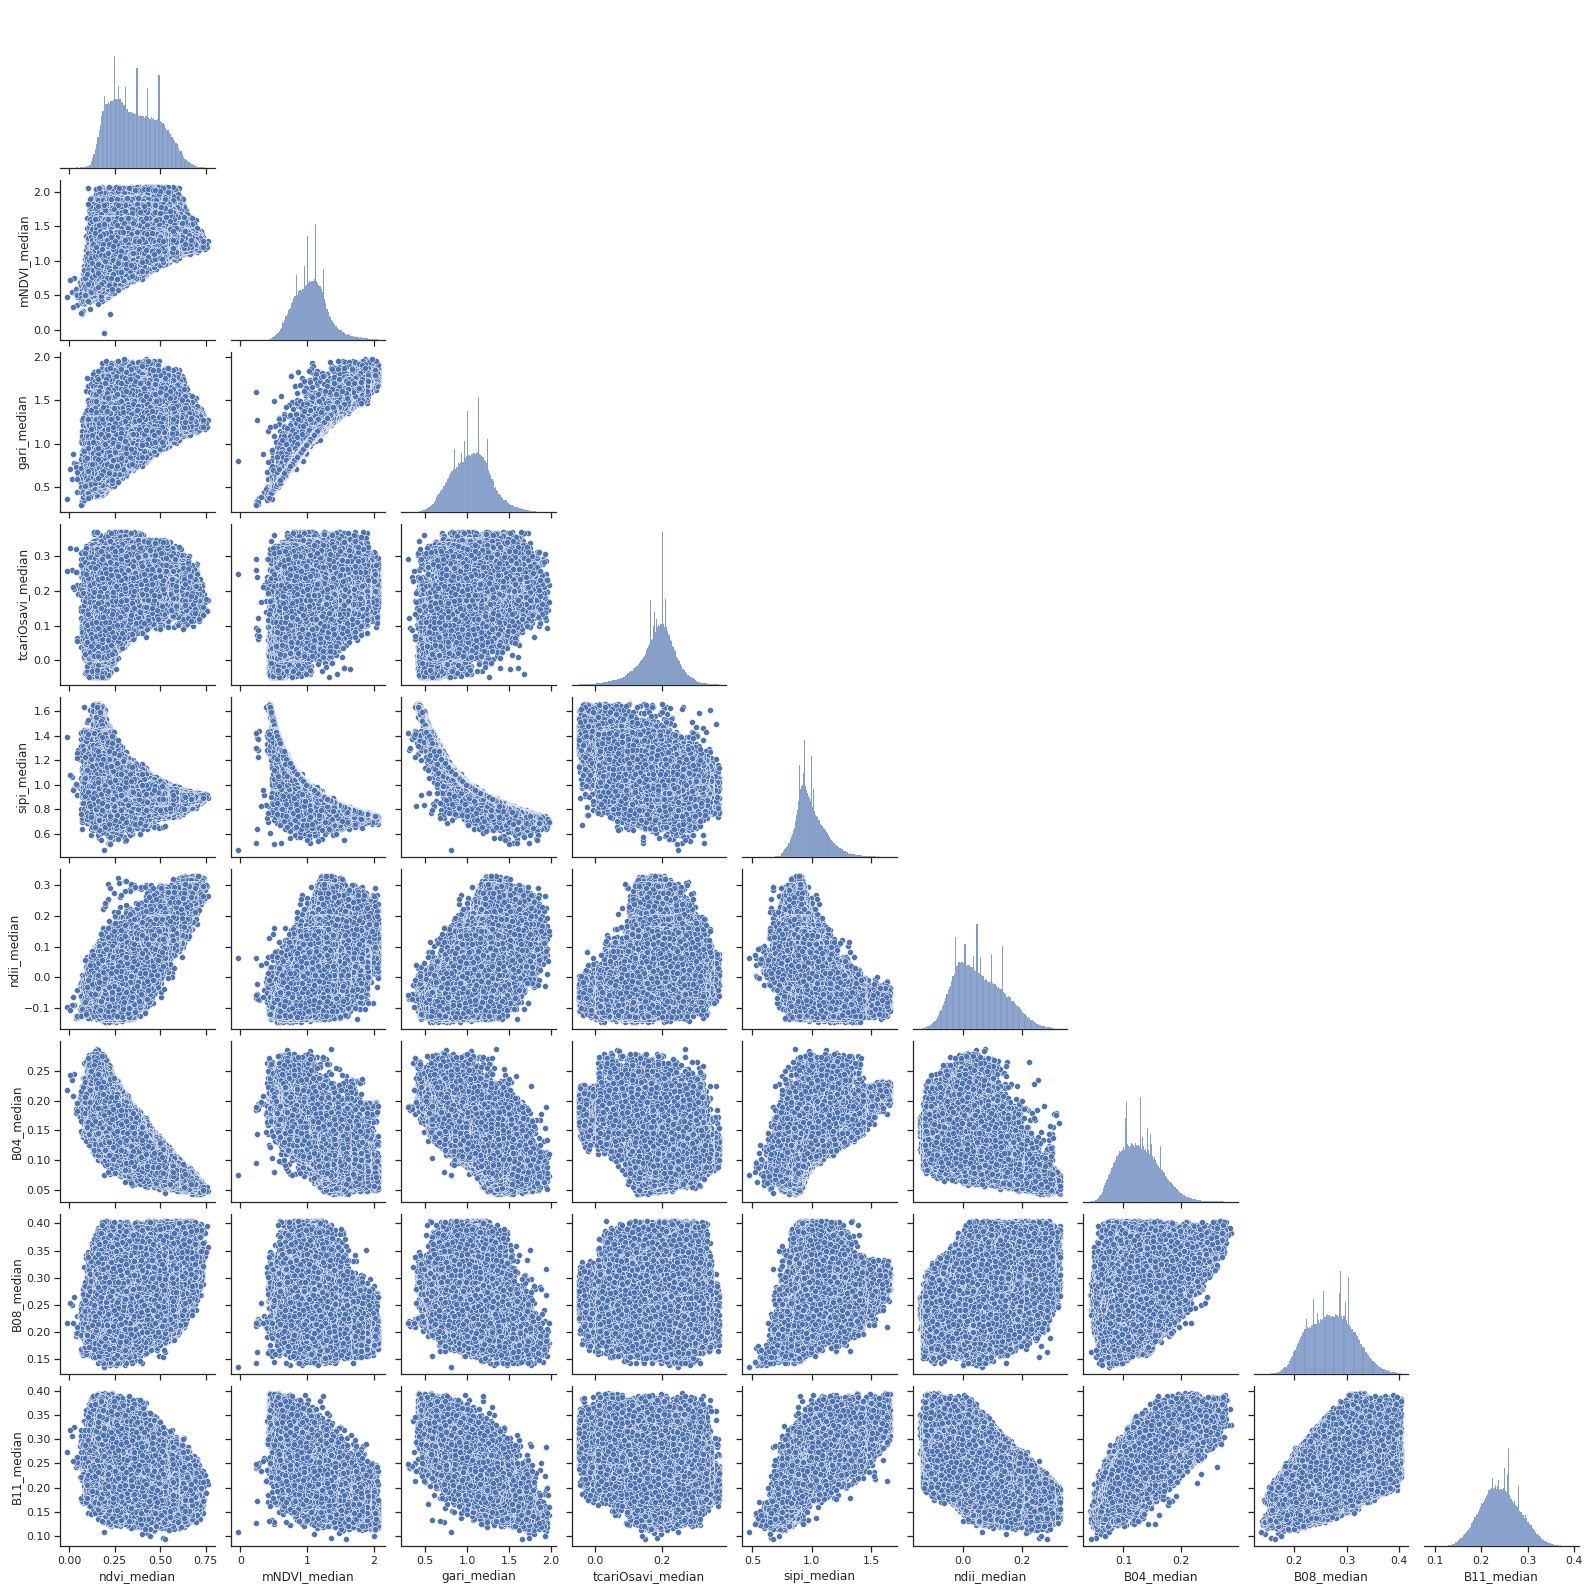

In [ ]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_D_km, vars=['ndvi_median', 'mNDVI_median', 'gari_median', 'tcariOsavi_median',
        'sipi_median', 'ndii_median', 'B04_median', 'B08_median', 'B11_median'], corner=True)

Los gráficos de dispersión de a pares no nos muestran posibles conglomerados. La distribución de cada variable numérica no presenta comportamiento bimodal o de alta variabilidad. Seguiremos el mismo esquema que el utilizado en la receta A.

**Elbow**

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

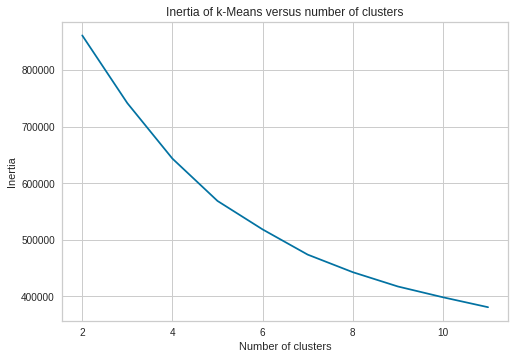

In [22]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i,random_state=10).fit(df_D_escal1[col_D]).inertia_ for i in range(2,12)]

plt.plot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

El codo nos dice que podríamos usar 3 o 4 clusters, dado que hemos quitado una variable de mucho peso en nuestro dataset nos apoyaremos en la puntuación de silueta para la elección de $k$

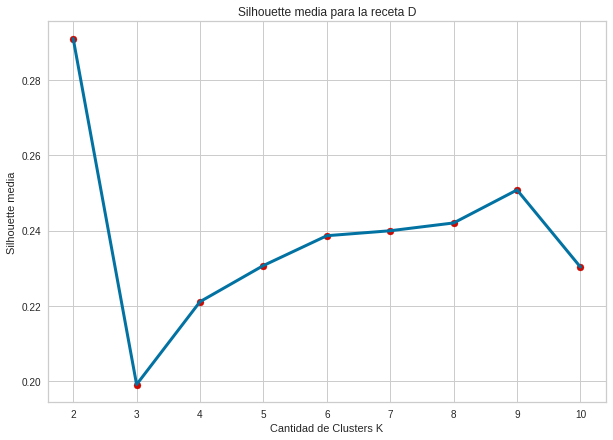

In [37]:
K = np.arange(2,11)

lista_sil = []

for k in range(2,11):
    km = KMeans(n_clusters=k)
    km = km.fit(df_D_escal1[col_D])
    
    etiquetas = km.labels_
    
    valor_medio_sil = silhouette_score(df_D_escal1[col_D], etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil, c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para la receta D')

plt.show()

El gráfico nos muestra que con un $k=2$ obtendríamos una puntuación de Silhouette de casi $0.30$. 



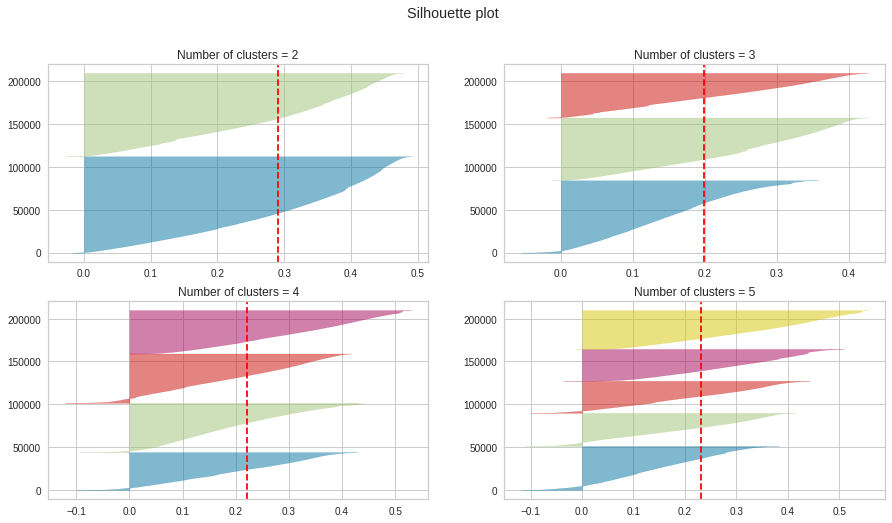

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(15,8)) 
for i in [2,3,4,5]: 
    ''' 
    Crear instancia de KMeans para diferentes números de clústeres 
    ''' 
    km = KMeans(n_clusters=i, init='k-means++', random_state=42) 
    q, mod = divmod(i, 2) 
    ''' 
    Crear instancia de SilhouetteVisualizer con instancia de KMeans 
    Ajuste el visualizador 
    ''' 
    visualizador = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod]) 
    visualizador.fit(df_D_escal1[col_D])

fig.suptitle("Silhouette plot")
ax[0, 0].title.set_text('Number of clusters = 2')
ax[0, 1].title.set_text('Number of clusters = 3')
ax[1, 0].title.set_text('Number of clusters = 4')
ax[1, 1].title.set_text('Number of clusters = 5')
plt.show()

Al igual que la receta A, en todos los casos la puntuación de silueta para cada grupo está por encima de las puntuaciones de silueta media. En el gráfico con n_cluster igual a $2$, el grosor es más uniforme que en el resto, además presentan menor cantidad de valores atípicos por cluster (porción de gráfico por debajo de cero). Por lo tanto, podemos seleccionar $k=2$.

**KMeans**

In [22]:
n_clust =2 #Se selecciona el número de clusters (k)

km_D = KMeans(n_clusters=n_clust, random_state=10)
km_D.fit(df_D_escal1[col_D]) #Se utiliza el df con las 34 dimensiones de habilidades para alimentar el algoritmo

clusters= km_D.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_D=df_D_escal1.copy() #Se hace una copia del df 
df_clusters_D['kmeans_clust'] = km_D.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km_D.labels_)+1, 'clusters')
df_clusters_D.head(4)

Nro Clusters encontrados:  2 clusters


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,raster,...,area_m2,espacio,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,estacion,week,kmeans_clust
0,0.929340,0.778555,0.766081,0.345414,-0.589862,0.992120,-0.991718,-0.110236,-0.931698,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,4650.710032,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,1
1,0.869643,0.040574,0.044745,0.807584,-0.016520,0.814113,-0.559006,0.966929,0.232925,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1502.000513,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,1
2,0.828132,0.032768,0.035832,0.187248,-0.009054,0.926890,-0.405797,1.102362,0.096322,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,2004.192528,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,1
3,1.146289,0.079950,0.084637,0.330829,-0.053624,1.228783,-0.457557,1.910235,0.452714,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,6940.507640,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,1


In [23]:
# Predicting the clusters
labels_D = km_D.predict(df_D_escal1[col_D])
# Getting the cluster centers
C_D = km_D.cluster_centers_

In [24]:
# C_D

**Graficamente**

3D

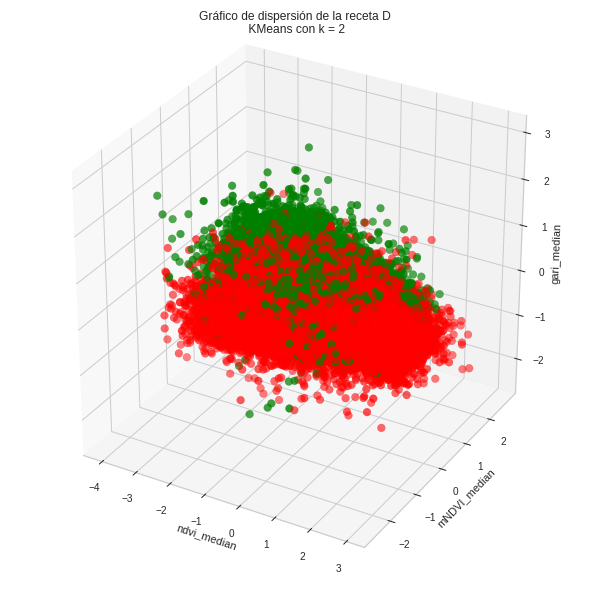

In [32]:

colores=['red','green']#,'yellow','orange']
asignar=[]
for row in labels_D:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(df_D_escal1.iloc[:, 3], df_D_escal1.iloc[:, 8],df_D_escal1.iloc[:, 2], c=asignar,s=60)
ax.scatter(C_D[:, 0], C_D[:, 1], C_D[:, 2], marker='*', c=colores, s=1000)
#ax.view_init(10,120) 

ax.set_xlabel('ndvi_median')
ax.set_ylabel('mNDVI_median')
ax.set_zlabel('gari_median')
plt.title(f'Gráfico de dispersión de la receta D\n KMeans con k = {n_clust}\n')
plt.show()

2D

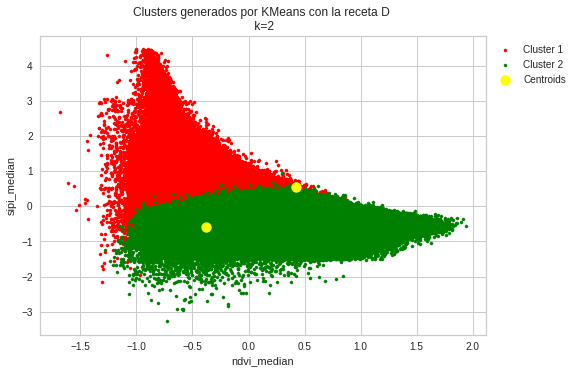

In [27]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_D.iloc[labels_D == 0, 0], df_clusters_D.iloc[labels_D == 0, 4], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_D.iloc[labels_D == 1, 0], df_clusters_D.iloc[labels_D == 1, 4], s = 10, c = 'green', label = 'Cluster 2')
# plt.scatter(df_clusters_D.iloc[labels_D == 2, 0], df_clusters_D.iloc[labels_D == 2, 2], s = 10, c = 'green', label = 'Cluster 3')
# plt.scatter(df_clusters_D.iloc[labels_D == 3, 0], df_clusters_D.iloc[labels_D == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(C_D[:, 0], C_D[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta D \n k={n_clust}')
plt.xlabel('ndvi_median')
plt.ylabel('sipi_median')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Los gráficos nos muestran que los cluster se superponen.

**Tablas de contingencia**

In [33]:
round(pd.crosstab(df_clusters_D.kmeans_clust, df_clusters_D.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.19,0.27,0.46
1,0.11,0.43,0.54
All,0.30,0.70,1.00


In [34]:
round(pd.crosstab(df_clusters_D.kmeans_clust, df_clusters_D.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.16,0.04,0.18,0.08,0.46
1,0.06,0.19,0.08,0.20,0.54
All,0.22,0.23,0.27,0.28,1.00


Con los datos escalados, no podemos caracterizar los clusters ni por espacio ni por estación.

**Contraste de etiquetas**

In [35]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_D.estacion, labels_D, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
Invierno,34097,12359,46456
Otoño,8595,40366,48961
Primavera,38363,17797,56160
Verano,16389,42009,58398
All,97444,112531,209975


In [36]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_D.espacio, labels_D, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,All
grupo_real,,,
0,40921,22615,63536
1,56523,89916,146439
All,97444,112531,209975


El análisis es similar al que realizamos en la receta D, las interpretaciones de los clusters no pueden girar alrededor de las variables espacio y estación. En el caso de espacios, si realizamos un reporte de clasificación suponiendo que en el cluster $0$ hay observaciones asociadas a espacios no verdes y en el $1$ observaciones relacionadas a espacios verdes, las métricas no serían buenas (además de considerar que los datos están desbalanceados). Respecto al accuracy que obtendríamos en la receta A, con los datos escalados esta métrica se ve mejorada ($0.52$ vs $0.62$)

In [37]:
from sklearn import metrics 
print(metrics.classification_report(df_clusters_D.espacio, labels_D))

              precision    recall  f1-score   support

           0       0.42      0.64      0.51     63536
           1       0.80      0.61      0.69    146439

    accuracy                           0.62    209975
   macro avg       0.61      0.63      0.60    209975
weighted avg       0.68      0.62      0.64    209975



Veamos qué sucede si quisieramos etiquetar las observaciones suponiendo estacionalidad. Para esto realizaremos un KMeans con $k=4$.

KMeans con $k=4$

In [59]:
n_clust =4 #Se selecciona el número de clusters (k)

km_D_1 = KMeans(n_clusters=n_clust, random_state=10)
km_D_1.fit(df_D_escal1[col_D]) #Se utiliza el df con las 34 dimensiones de habilidades para alimentar el algoritmo

clusters= km_D_1.labels_ # Etiquetas asignadas por el algoritmo, usaremos esta variable mas adelante en las gráficas
df_clusters_D_1=df_D_escal1.copy() #Se hace una copia del df 
df_clusters_D_1['kmeans_clust'] = km_D_1.labels_ #Se agrega la columna kmeans_clust para almacenar las etiquetas asignadas por el algoritmo
print('Nro Clusters encontrados: ', max(km_D_1.labels_)+1, 'clusters')
df_clusters_D_1.head(4)

Nro Clusters encontrados:  4 clusters


,ndvi_median,mNDVI_median,gari_median,tcariOsavi_median,sipi_median,ndii_median,B04_median,B08_median,B11_median,raster,...,area_m2,espacio,mes,estacion_Invierno,estacion_Otoño,estacion_Primavera,estacion_Verano,estacion,week,kmeans_clust
0,0.929340,0.778555,0.766081,0.345414,-0.589862,0.992120,-0.991718,-0.110236,-0.931698,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,4650.710032,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,0
1,0.869643,0.040574,0.044745,0.807584,-0.016520,0.814113,-0.559006,0.966929,0.232925,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,1502.000513,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,0
2,0.828132,0.032768,0.035832,0.187248,-0.009054,0.926890,-0.405797,1.102362,0.096322,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,2004.192528,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,0
3,1.146289,0.079950,0.084637,0.330829,-0.053624,1.228783,-0.457557,1.910235,0.452714,S2A_MSIL1C_20170103T142022_N0204_R010_T20JLL_2...,...,6940.507640,1,-0.857143,0.0,0.0,0.0,1.0,Verano,-0.892857,0


In [60]:
# Predicting the clusters
labels_D_1 = km_D_1.predict(df_D_escal1[col_D])
# Getting the cluster centers
C_D_1 = km_D_1.cluster_centers_

In [ ]:

# dist = np.sqrt(np.sum(np.square(C_D_1[0]-C_D_1[1])))

# print(dist)


**Gráficamente**

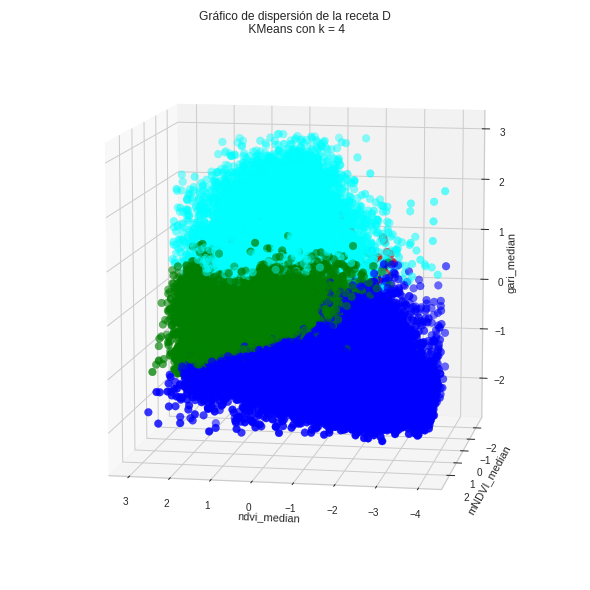

In [62]:

colores=['red','green','blue','cyan']
asignar=[]
for row in labels_D_1:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(df_D_escal1.iloc[:, 3], df_D_escal1.iloc[:, 8],df_D_escal1.iloc[:, 2], c=asignar,s=60)
ax.scatter(C_D_1[:, 0], C_D_1[:, 1], C_D_1[:, 2], marker='*', c=colores, s=100)
ax.view_init(10,100) 

ax.set_xlabel('ndvi_median')
ax.set_ylabel('mNDVI_median')
ax.set_zlabel('gari_median')
plt.title(f'Gráfico de dispersión de la receta D\n KMeans con k = {n_clust}\n')
plt.show()

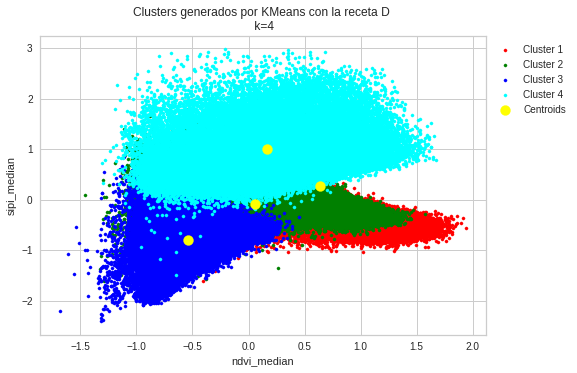

In [63]:
# Visualizacion grafica de los clusters en 2D
plt.scatter(df_clusters_D_1.iloc[labels_D_1 == 0, 0], df_clusters_D_1.iloc[labels_D_1 == 0, 4], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(df_clusters_D_1.iloc[labels_D_1 == 1, 0], df_clusters_D_1.iloc[labels_D_1 == 1, 4], s = 10, c = 'green', label = 'Cluster 2')
plt.scatter(df_clusters_D_1.iloc[labels_D_1 == 2, 0], df_clusters_D_1.iloc[labels_D_1 == 2, 2], s = 10, c = 'blue', label = 'Cluster 3')
plt.scatter(df_clusters_D_1.iloc[labels_D_1 == 3, 0], df_clusters_D_1.iloc[labels_D_1 == 3, 2], s = 10, c = 'cyan', label = 'Cluster 4')


plt.scatter(C_D_1[:, 0], C_D_1[:, 1], s = 100, c = 'yellow', label = 'Centroids')

plt.title(f'Clusters generados por KMeans con la receta D \n k={n_clust}')
plt.xlabel('ndvi_median')
plt.ylabel('sipi_median')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

**Tablas de contingencia**

In [66]:
round(pd.crosstab(df_clusters_D_1.kmeans_clust, df_clusters_D_1.estacion, margins=True, normalize=True),2)

estacion,Invierno,Otoño,Primavera,Verano,All
kmeans_clust,,,,,
0,0.00,0.03,0.00,0.21,0.24
1,0.05,0.04,0.17,0.02,0.27
2,0.12,0.02,0.09,0.04,0.28
3,0.05,0.14,0.01,0.01,0.21
All,0.22,0.23,0.27,0.28,1.00


In [68]:
round(pd.crosstab(df_clusters_D_1.kmeans_clust, df_clusters_D_1.espacio, margins=True, normalize=True),2)

espacio,0,1,All
kmeans_clust,,,
0,0.05,0.19,0.24
1,0.07,0.20,0.27
2,0.13,0.15,0.28
3,0.05,0.16,0.21
All,0.30,0.70,1.00


**Contraste de etiquetas**

In [65]:
# Tabla de contingencia: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_D_1.espacio, labels_D_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,All
grupo_real,,,,,
0,10344,14405,27338,11449,63536
1,40341,42673,30638,32787,146439
All,50685,57078,57976,44236,209975


In [69]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab( df_clusters_D_1.estacion, labels_D_1, dropna=False, rownames=['grupo_real'], colnames=['cluster'], margins=True)

cluster,0,1,2,3,All
grupo_real,,,,,
Invierno,0,10579,26082,9795,46456
Otoño,7047,7654,4498,29762,48961
Primavera,156,35082,18185,2737,56160
Verano,43482,3763,9211,1942,58398
All,50685,57078,57976,44236,209975


Esta matriz de confusión nos da muchos falsos positivos y falsos negativos, pero supongamos que decidieramos caracterizar al cluster $0$ con los registros relacionados con el verano, en el $1$ las observaciones de primavera, en el $2$ de invierno y en el $3$ registros otoñales (tomamos a estos valores como labels predichos). Cuando hacemos el reporte de clasificación (ya que conocemos la verdad), vemos que las métricas no son buenas.

In [79]:
df_cluster_D_2=df_clusters_D_1.copy()

In [80]:
estacion_dict={ 
   
    'Verano': 0,
    'Primavera': 1,
    'Invierno': 2,
    'Otoño': 3
 }


df_cluster_D_2["estacion_num"]=df_cluster_D_2.estacion.replace(estacion_dict)

In [82]:
from sklearn import metrics 
print(metrics.classification_report(df_cluster_D_2.estacion_num, labels_D_1, target_names = ['Verano', 'Primavera', 'Invierno', 'Otoño'], digits=4))

              precision    recall  f1-score   support

      Verano     0.8579    0.7446    0.7972     58398
   Primavera     0.6146    0.6247    0.6196     56160
    Invierno     0.4499    0.5614    0.4995     46456
       Otoño     0.6728    0.6079    0.6387     48961

    accuracy                         0.6401    209975
   macro avg     0.6488    0.6346    0.6388    209975
weighted avg     0.6594    0.6401    0.6469    209975

